# Predicting Log Errors in Single Unit Zestimates at Zillow
***

# Goal
Build a model that can predict the log error of single unit estimates from Zillow
***

# Acquire<a name="acquire"></a>
Acquire the data I need for the project from the zillow table in the data science database.

Create __acquire.py__ file that contains the functions needed to replicate this process.
***

In [1]:
# set up environment
from acquire import get_zillow_data
from prep import drop_missing_columns, missing_rows, drop_selected_columns, compare_column_values,\
tax_columns_calculator, split_data, data_scaler, d_type_convert, zillow_dummy, column_sort_rename, final_prep
from model import baseline_function, model_1_function, model_2_function, model_3_function, model_4_function

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

#### Using get_zillow_data function (acquire.py)  to import data 

In [2]:
# create variable that will hold DF for easy access to data
df = get_zillow_data()

# previewing data
df.head(2)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,parcelid.1,logerror,transactiondate
0,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,12177905,-0.10341,2017-01-01
1,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,4,10887214,0.00694,2017-01-01


In [3]:
df.shape

(47414, 63)

### ACQUIRE TAKEAWAYS
- Acquiring data from zillow database on the data science database server using the __get_zillow_data__ function
- Function needed to replicate this phase is located in the __acquire.py__ file
***

# Prepare
Prepare, tidy, and clean the data for exploration and modeling.

Create __prep.py__ file that contains the functions needed to replicate this process.

Create __final_prep (prep.py)__ function that acquires and fully prepares the data with all of the changes outlined in the prepare section. Useful if a user prefers not to run each function in the acquire and prepare sections individually.
***

### I'll use .info to see null value counts, data types, and row / columns count.

In [4]:
# using info function to examine data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47414 entries, 0 to 47413
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            47414 non-null  int64  
 1   parcelid                      47414 non-null  int64  
 2   airconditioningtypeid         22070 non-null  float64
 3   architecturalstyletypeid      0 non-null      float64
 4   basementsqft                  0 non-null      float64
 5   bathroomcnt                   47414 non-null  float64
 6   bedroomcnt                    47414 non-null  float64
 7   buildingclasstypeid           8 non-null      float64
 8   buildingqualitytypeid         46923 non-null  float64
 9   calculatedbathnbr             47368 non-null  float64
 10  decktypeid                    0 non-null      float64
 11  finishedfloor1squarefeet      0 non-null      float64
 12  calculatedfinishedsquarefeet  47407 non-null  float64
 13  f

- Many columns have a large amount of null values
    - I'll be using the __drop_missing_columns (prep.py)__ function to drop columns with 40% or more of their values missing
    - I could impute them, but with so many values missing, I'm wary that the values I choose to impute them with (median, mean, etc.) may not be a good representation of the population


- Data types of several columns need to be converted 
    - I'll handle this in a later stage since the columns in question may be removed in an alternate step 
        - For example, I may remove a column with a bad data type due to it having too many nulls


- Several columns, such as rawcensustractandblock, are categorical variables that may have a very large amount of unique values

        
        
- The transaction date is only known when the property is sold, I'm trying to created a model that Zillow can use on properties before they have been sold
    - transactiondate will be dropped as it will not be useful in a real-world setting as a result of this


- Dropping tax_amount as it was specified that this column was not allowed to be used in the given project specs



- Once I've identified which columns to move into exploration with, I'll need to rename them if they are hard to read, such as landtaxvaluedollarcnt


### There are several columns with large amounts of values missing. 
I could impute them, but with so many rows missing, using the average or median within them may not be indicative of the population. I'm going to use the __drop_missing_columns (prep.py)__ to remove columns that are missing 40% or more of their values.

In [5]:
# function removes any columns that are missing 40% or more of their values
df = drop_missing_columns(df)

# previewing data
df.head()

,id,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,id.1,parcelid.1,logerror,transactiondate
0,2288172,12177905,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,3.0,...,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,3,12177905,-0.103410,2017-01-01
1,1970746,10887214,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,3.0,...,73681.0,119407.0,2016.0,45726.0,1533.89,6.037124e+13,4,10887214,0.006940,2017-01-01
2,781532,12095076,3.0,4.0,9.0,3.0,2962.0,2962.0,6037.0,3.0,...,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,6,12095076,-0.001011,2017-01-01
3,870991,12069064,1.0,2.0,5.0,1.0,738.0,738.0,6037.0,1.0,...,18890.0,218552.0,2016.0,199662.0,2366.08,6.037302e+13,7,12069064,0.101723,2017-01-01
4,1246926,12790562,3.0,4.0,9.0,3.0,3039.0,3039.0,6037.0,3.0,...,177527.0,220583.0,2016.0,43056.0,3104.19,6.037500e+13,8,12790562,-0.040966,2017-01-02


### While examining the data in SQL, I noticed that several columns appeared to have identical values. 
I'm going to use __compare_column_values (prep.py)__ to find how many unique values exist between the columns in question.

In [6]:
# function prints out sum of unique values between various columns
compare_column_values(df)

Number of different values between finishedsquarefeet12 and calculatedfinishedsquarefeet: 48
Number of different values between calculatedbathnbr and bathroomcnt: 46
Number of different values between fullbathcnt and bathroomcnt: 46


- The sum of non-duplicate values between all of these columns is 140 (48 + 46 + 46). 
    - This is roughly .003 of all rows in the DF
        - We can safely drop all the following majority-duplicate columns and only lose a extremely small proportion of rows.
            - finishedsquarefeet12
            - calculatedbathnbr
            - fullbathcnt
        - We could drop any of their alternativee columns instead but it would cost us time to find a non-arbitrary reason to do so and given how few unique values we're losing, the loss is relatively inconsequential.
        - These columns will be dropped in an upcoming function, __drop_selected_columns__ (prep.py), along with any other columns that are found to be in need of removal.

### While examining the data in SQL, we noticed that taxvaluedollarcnt appeared to be the sum of landtaxvaluedollarcnt and structuretaxvaluedollarcnt. 
To test this I'm going to use __tax_columns_calculator (prep.py)__ to compare the sums of landtaxvaluedollarcnt and structuretaxvaluedollarcnt  to the values in taxvaluedollarcnt.

In [7]:
# function sums landtaxvaluedollarcnt and structuretaxvaluedollarcnt then prints the percent of rows where the sum matched taxvaluedollarcnt
tax_columns_calculator(df)

0.9986501877082719


- 99% of the the summed values matched the original 
    - In a vast majority of rows, taxvaluedollarcnt is the sum of landtaxvaluedollarcnt and structuretaxvaluedollarcnt
        - This being the case, I'm only going to keep taxvaluedollarcnt and remove the other two columns since their values are already accounted for in this column.
        - If need be, I can add them back later and see if I get better results by having them seperated.
        - The columns will be dropped at a later step using the __drop_selected_columns__ (prep.py) function 

### I'm using .nunique to see how many unique values each column has. This is useful for identifying categorical columns with large amounts of unique values and columns with only a single value.

In [8]:
# nunique() displays each column and the amount of unique values that it holds
df.nunique()

id                              47293
parcelid                        47293
bathroomcnt                        13
bedroomcnt                         12
buildingqualitytypeid              12
calculatedbathnbr                  12
calculatedfinishedsquarefeet     4302
finishedsquarefeet12             4300
fips                                3
fullbathcnt                        12
heatingorsystemtypeid               3
latitude                        38668
longitude                       37041
lotsizesquarefeet               16506
propertycountylandusecode          40
propertylandusetypeid              10
propertyzoningdesc               1854
rawcensustractandblock          25212
regionidcity                      135
regionidcounty                      3
regionidzip                       290
roomcnt                             5
unitcnt                             1
yearbuilt                         131
structuretaxvaluedollarcnt      28782
taxvaluedollarcnt               32671
assessmentye

- The following categorical columns will be removed because they contain a large amount of unique values. Encoding them may be computationaly expensive and would add a large amount of columns to our dataframe.

    - id
    - parcelid
    - propertycountylandusecode
    - propertyzoningdesc
    - rawcensustractandblock
    - regionidcity
    - regionidzip
    - censustractandblock
    - id.1
    - parcelid.1 
    
- There are ways to avoid the consequences of encoding categorical columns with lots of features, but in the interest of time I'll avoid these routes for now.


- Will also be dropping columns that have an identical value in each row


- All of these columns will be removed using the __drop_selected_columns (prep.py)__ function

### Using __drop_selected_columns__ to drop columns listed in the sections above

In [9]:
# function drops various columns
drop_selected_columns(df)

df.head(2)

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,yearbuilt,taxvaluedollarcnt,logerror
0,3.0,4.0,8.0,2376.0,2.0,34245180.0,-118240722.0,13038.0,261.0,1970.0,145143.0,-0.10341
1,3.0,3.0,8.0,1312.0,2.0,34185120.0,-118414640.0,278581.0,266.0,1964.0,119407.0,0.00694


### Some of the columns are probably still missing data so I'll use the missing_rows (prep.py) function again to find what overall percent of rows are missing values.

In [10]:
# passing dataframe to missing_rows function
missing_rows_df = missing_rows(df)

# summing values in the percent of rows missing column
total_percent_rows_missing = round((missing_rows_df.pct_rows_missing).sum(),0)

print(f'At most, {total_percent_rows_missing}% of rows contain missing values.')

At most, 5.0% of rows contain missing values.


- Given how small this percentage is, it should be relatively inconsequential to drop rows with missing values

### Dropping remaining rows with missing values

In [11]:
# drop all rows with missing values
df.dropna(inplace = True)

### Data Types
Updating data types as needed for operations using __d_type_convert (prep.py)__ function.

In [12]:
# converting data types via d_type_convert function from prep.py
df = d_type_convert(df)

- Updating float columns to integer columns if they only contain whole numbers 
- After this change, all columns with have an approriate type for the operations I intend to perform on them
    - May need to update some later if their typing is not a good fit for new operations 

### Encoding
Using __zillow_dummy (prep.py)__ function to create dummy columns for a each categorical column

In [13]:
# saving resulting df to variable
df = zillow_dummy(df)

# previewing dummy data
df.head(2)

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,yearbuilt,...,heatingorsystemtypeid_20,propertylandusetypeid_31,propertylandusetypeid_246,propertylandusetypeid_247,propertylandusetypeid_260,propertylandusetypeid_261,propertylandusetypeid_264,propertylandusetypeid_266,propertylandusetypeid_267,propertylandusetypeid_269
0,3,4,8,2376.0,2,34245180,-118240722,13038,261,1970,...,0,0,0,0,0,1,0,0,0,0
1,3,3,8,1312.0,2,34185120,-118414640,278581,266,1964,...,0,0,0,0,0,0,0,1,0,0


- Dummy variables added succesfully, now we can split the data


### Sort and rename columns
Tidying columns via sorting (ie. boolean columns and their sources are next to each other, target variable is last column in DF)

In [14]:
df = column_sort_rename(df)

### Split Data
Using __split_data (prep.py)__ function to split data into train, validate and test samples

In [15]:
# function splits data into train, validate and test samples
train, validate, test = split_data(df)

# using shape to see count of rows and columns
train.shape

(25256, 35)

- We use .shape to confirm our number of rows reflects a split and it has

### Outliers

Normally the formula below uses a value of 1.5 instead of 6 but in order to narrow the scope to only extreme outliers, I elected to use a value of 6. By focusing on only extreme outliers, my intent was to preserve as much data as possible.

Outlier formulas

- Lower extreme outlier = q1 - (6 * IQR)
- Upper extreme outlier = q3 + (6 * IQR)

__UPDATE:__ Although clusters are sensitive to outliers, these outliers appear to be legitimately extreme values and not erroneous data. For these reasons I'm going to leave them in for this iteration of the project. Although clusters are usually negatively impacted by outliers, I think it's important to preserve these data points as they represent the extreme values that certain variables may have at times. 

### Scaling
Using __data_scaler (prep.py)__ function to scale the data within the non-categorical and non-target variable columns. I'll be keeping a set of unscaled dataframes for things such as visualizations.

In [16]:
# scaling appropriate numerical columns
train_scaled, validate_scaled, test_scaled = data_scaler(train, validate, test)

# previewing dataframe
train_scaled.head(2)

,bathroom_count,bedroom_count,property_sqft,latitude,longitude,lotsize_sqft,year_built,tax_dollar_value,building_quality_type_id,buildingqualitytypeid_1,...,propertylandusetypeid_31,propertylandusetypeid_246,propertylandusetypeid_247,propertylandusetypeid_260,propertylandusetypeid_261,propertylandusetypeid_264,propertylandusetypeid_266,propertylandusetypeid_267,propertylandusetypeid_269,log_error
23152,0.181818,0.272727,0.104161,0.256698,0.483792,0.001421,0.522388,0.029897,6,0,...,0,0,0,0,1,0,0,0,0,0.028731
29888,0.181818,0.181818,0.091822,0.338196,0.412719,0.004482,0.686567,0.029523,7,0,...,0,0,0,0,0,0,1,0,0,0.011302


- Data scaled successfully
- I'm not scaling any of our categorical columns 
    - They are all binary values between 0 and 1 and thus don't need scaling
- I'm not scaling logerror as there's no need since its the target variable

### PREPARE TAKEAWAYS
- Dropped all columns that met any of the following criterion
    - 40% or more of their values missing
    - Duplicate or near-duplicate of other column(s)
    - Categorical with 20+ unique values
    - Entire column holds identical value
    - landtaxvaluedollarcnt and structuretaxvaluedollarcnt as they are summed as taxvaluedollarcnt
    - calculatedbathnbr and fullbathcnt as they are near duplicates of bathroomcnt
    
    
- Created boolean columns for all categorical values


- Updated data types


- After changes above completed, I dropped all rows that with missing values (approximately 5% of overall rows)


- Scaled all numeric non-categorical, non-target variables


- Data types are valid


- Split data into train, validate and test (scaled and unscaled) sets


- Renamed columns for readability


- All custom functions in this phase can be found in the __prepare.py__ and __prep.py__ files


- To acquire and fully prepare without any of the previous functions, you can alternatively run the __final_prep__ function (no arguments needed) from the __prep.py__ file. 
***

# Explore
I will now explore the prepped data to identify relationships between variables.

Clustering will also be employed to aid me in the last section of exploration.
***

# Non-Clustered Exploration

I'm going to begin exploration by creating using visualizations and hypothesis tests to gauge the relationships between non-target variables and the target variable. 
***

## Feature: property_sq_ft
How does the square feet of a property relate to log error. 

### Visualization - property_sqft<a name="nce"></a>
Plotting the relationship between property_sq_ft and log_error

Text(0, 0.5, 'Log Error of Zestimate')

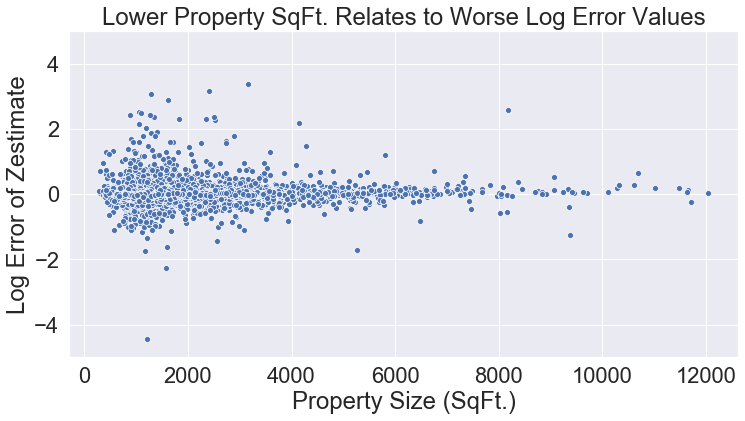

In [17]:
# setting figure and text size for plot
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale = 2)

# creating scatter plot and setting title
plt.ylim([-5, 5])
sns.scatterplot(x = 'property_sqft', y = 'log_error', data = train).set_title("Lower Property SqFt. Relates to Worse Log Error Values")

# setting x and y labels
plt.xlabel("Property Size (SqFt.)")
plt.ylabel("Log Error of Zestimate")

- The farther away from 0 a zestimate's log error is, the farther off from reality the zestimate was

- Generally, the smaller properties have log error values farther from 0 and thus different on average than other properties

### Hypothesis Test - property_sq_ft
#### Going to perform a two tailed, two sample t-test to see if smaller properties have different log error values than other  properties.

- H0 = Average log errors of properties with less than average property_sq_ft __=__ Average log errors of properties with average or above property_sq_ft
- Ha = Average log errors of properties with less than average property_sq_ft __!=__ Average log errors of properties with average or above property_sq_ft

In [18]:
# finding avg property_sq_ft
avg_property_sqft = train.property_sqft.mean()

# x1 = df of properties with property_sq_ft less than the avg.
# x2 = df of properties with property_sq_ft greater than or equal to the avg.
x1 = train[train.property_sqft < avg_property_sqft].log_error
x2 = train[train.property_sqft >= avg_property_sqft].log_error

# performing 2 tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 2.003100747679599e-05


- p is below our alpha (.05) so I'm rejecting the null hypothesis and concluding there is evidence that properties with less than average square feet have different log error values than those with average or above property square feet

- In light of this, I'll keep this variable as a candidate for modeling

## Feature: lotsize_sqft
Let's now explore how lotsize_sqft relates to log error. 

### Visualization - lotsize_sqft
#### Plotting the relationship between lotsize_sqft and log_error

Text(0, 0.5, 'Log Error of Zestimate')

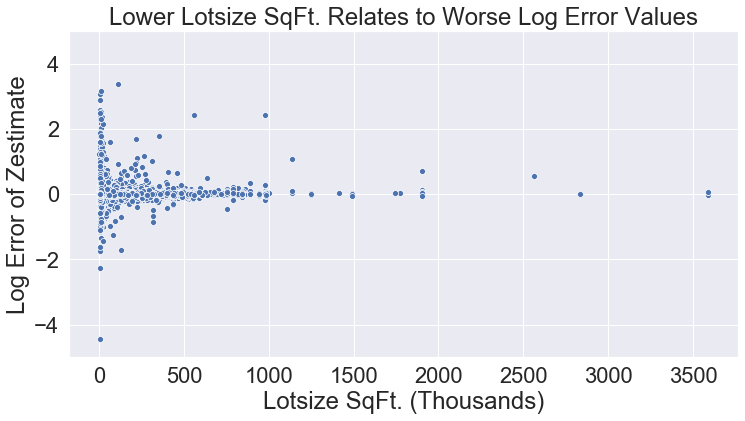

In [19]:
# setting figure and text size for plot
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale = 2)

# creating scatter plot and setting title
plt.ylim([-5, 5])
sns.scatterplot(x = train['lotsize_sqft']/1000, y = 'log_error', data = train).set_title("Lower Lotsize SqFt. Relates to Worse Log Error Values")

# setting x and y labels
plt.xlabel("Lotsize SqFt. (Thousands)")
plt.ylabel("Log Error of Zestimate")

- Properties with smaller lotsizes appear to have log error values that are farther from 0
- I'm going to perform a t-test to confirm if smaller properties have different log error values than other properties

### Hypothesis Test - lot size_sqft
#### Performing a two tailed, two sample t-test to see if properties with smaller lotsizes have different log error values than other  properties.

- H0 = Average log errors of properties with below avg. lot size_sqft __=__ Average log errors of properties with avg. or above avg. lot size_sqft
- Ha = Log error of properties with below avg. lot size_sqft __!=__ Log error of properties with avg. or above avg. lot size_sqft

In [20]:
# finding avg property_sq_ft
avg_lotsize_sqft = train.lotsize_sqft.mean()

# x1 = df of properties with property_sq_ft less than the avg.
# x2 = df of properties with property_sq_ft greater than or equal to the avg.
x1 = train[train.lotsize_sqft < avg_lotsize_sqft].log_error
x2 = train[train.lotsize_sqft >= avg_lotsize_sqft].log_error

# performing 2 tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 0.9648685690598503


- p is greater than alpha so I fail to reject the null hypothesis
- I won't be using this feature further

## Feature: tax_dollar_value
I'm now going to explore how tax dollar value relates to log error. 

### Visualization - tax_dollar_value
#### Plotting the relationship between tax_dollar_value and log_error

Text(0, 0.5, 'Log Error of Zestimate')

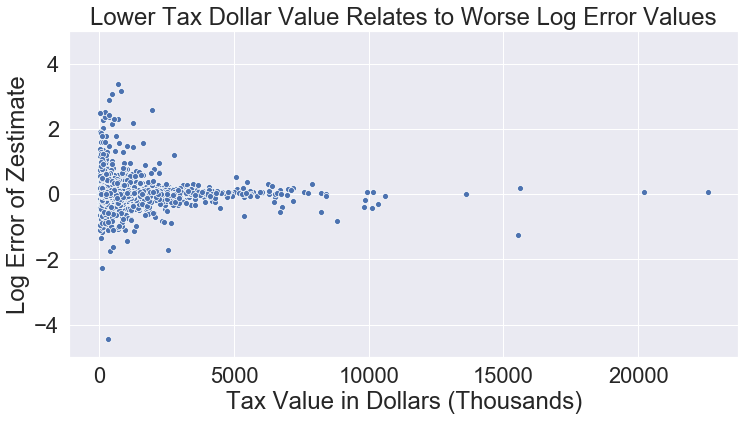

In [21]:
# setting figure and text size
sns.set(rc = {'figure.figsize':(12,6)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling x axis values to simplify them
plt.ylim([-5, 5])
sns.scatterplot(x = train['tax_dollar_value'] / 1000, y = 'log_error', data = train).set_title("Lower Tax Dollar Value Relates to Worse Log Error Values")
plt.xlabel("Tax Value in Dollars (Thousands)")
plt.ylabel("Log Error of Zestimate")

- This visual looks very similar to the previous one and has similar takeaways

- The farther away from 0 a zestimate's log error is, the farther off from reality the zestimate was

- The lower value properties appear to have more log error values that are more distant from 0 than the higher value properties

### Hypothesis Test - tax_dollar_value

#### Performing a two tailed, two sample t-test to see if properties with lower tax dollar values have different log error values than other properties.

- H0 = Log error of properties with below avg. tax_dollar_value __=__ Log error of properties with avg. or above avg. tax_dollar_value
- Ha = Log error of properties with below avg. tax_dollar_value __!=__ Log error of properties with avg. or above avg. tax_dollar_value 

In [22]:
# finding avg tax dollar value
avg_tax_dollar_value = train.tax_dollar_value.mean()

# x1 = df of properties with tax dollar value less than the avg.
# x2 = df of properties with tax dollar value greater than or equal to the avg.
x1 = train[train.tax_dollar_value < avg_tax_dollar_value].log_error
x2 = train[train.tax_dollar_value >= avg_tax_dollar_value].log_error

# performing 2 tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 0.019160950161925042


- p is below alpha (.05) so I reject the null hypothesis and conclude there is evidence that properties with lower sqft. have different log error values than high value properties
       
- Based on these observations, tax_dollar_value is a prospective feature for modeling

## Feature: bedroom_count
Let's now explore how the number of bathrooms in a property relates to log error. 

### Visualization - bedroom_count
#### We will plot the relationship between bedroom_count and log_error

Text(0, 0.5, 'Log Error of Zestimate')

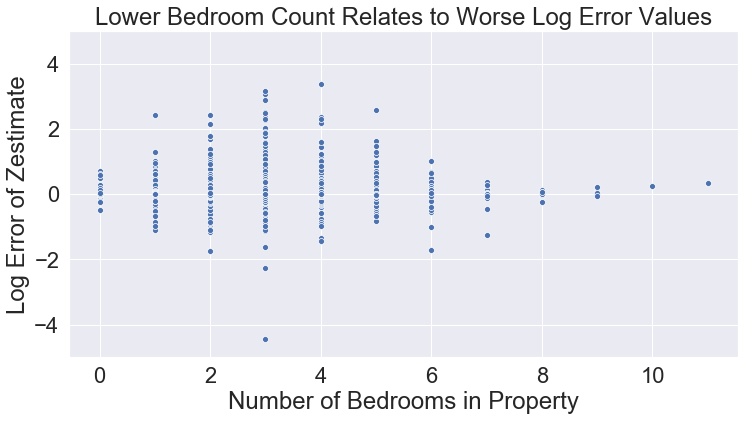

In [23]:
# setting figure size
sns.set(rc = {'figure.figsize':(12,6)})

# setting font size
sns.set(font_scale = 2)

# plotting scatterplot and setting title
plt.ylim([-5, 5])
sns.scatterplot(x = 'bedroom_count', y = 'log_error', data = train).set_title("Lower Bedroom Count Relates to Worse Log Error Values")

# setting x and y label
plt.xlabel("Number of Bedrooms in Property")
plt.ylabel("Log Error of Zestimate")

- As the number of bedrooms decreases, log error values pull farther away from 0
    - In other words, it appears that the less bedrooms a property has, the worse its corresponding zestimate tends to be
        - Interestingly, this does not appear to be true for properties with no bedrooms
            - If a property has no bedrooms, it may be a special kind of property that Zillow is able to evaluate more accurately

### Hypothesis Test - bedroom_count

#### Performing a two tailed, two sample t-test to see if properties with less bedrooms have different log error values than other properties.

- H0 = Log error of properties with below avg. bedroom_count __=__ Log error of properties with avg. or above avg. bedroom_count
- Ha = Log error of properties with below avg. bedroom_count __!=__ Log error of properties with avg. or above avg. bedroom_count

In [24]:
# finding avg bedroom_count
avg_bedroom_count = train.bedroom_count.mean()

# x1 = df of properties with bedroom_count less than the avg.
# x2 = df of properties with bedroom_countgreater than or equal to the avg.
x1 = train[train.bedroom_count < avg_bedroom_count].log_error
x2 = train[train.bedroom_count >= avg_bedroom_count].log_error

# performing 2 tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 0.00027403758260413055


- p is below our alpha (.05) so I reject the null hypothesis and conclude there is evidence that properties with lower than avg. bedroom counts have different log errors than properties with the avg. or more than the avg. number of bedrooms

- Based on these findings, I may use this variable in modeling

## Feature: bathroom_count

### Visualization - bathroom_count
#### I will plot the relationship between bedroom_count and log_error

Text(0, 0.5, 'Log Error of Zestimate')

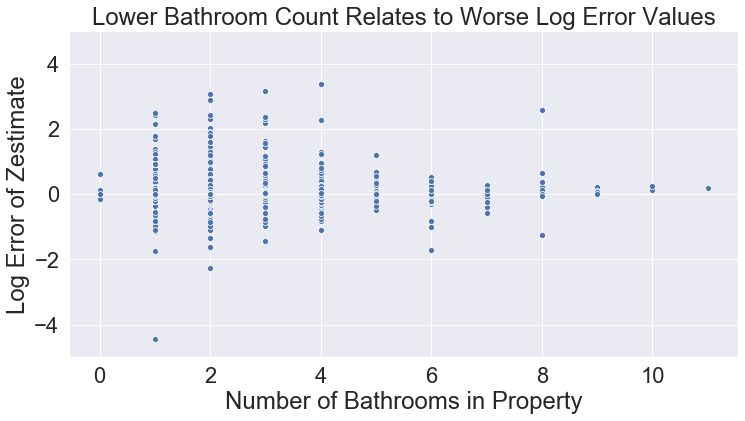

In [25]:
# setting figure size
sns.set(rc = {'figure.figsize':(12,6)})

# setting font size
sns.set(font_scale = 2)

# plotting scatterplot and setting title
plt.ylim([-5, 5])
sns.scatterplot(x = 'bathroom_count', y = 'log_error', data = train).set_title("Lower Bathroom Count Relates to Worse Log Error Values")

# setting x and y label
plt.xlabel("Number of Bathrooms in Property")
plt.ylabel("Log Error of Zestimate")

- As the number of bathrooms decreases, log error values tend to pull farther away from 0
- Like bedrooms, this does not appear to be true for properties with no bathrooms 
    - If a property has no bathrooms, it may be a special kind of property that Zillow is able to evaluate more accurately

### Hypothesis Test - bathroom_count

#### Performing a two tailed, two sample t-test to see if properties with less bathrooms have different log error values than other properties.

- H0 = Log error of properties with below avg. bathroom_count __=__ Log error of properties with avg. or above avg. bathroom_count
- Ha = Log error of properties with below avg. bathroom_count __!=__ Log error of properties with avg. or above avg. bathroom_count

In [26]:
# finding avg bedroom_count
avg_bathroom_count = train.bathroom_count.mean()

# x1 = df of properties with bathroom_count less than the avg.
# x2 = df of properties with bathroom_count greater than or equal to the avg.
x1 = train[train.bathroom_count < avg_bathroom_count].log_error
x2 = train[train.bathroom_count >= avg_bathroom_count].log_error

# performing 2 tailed, 2 sample t-test
t, p = stats.ttest_ind(x1, x2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 0.00010326573525738695


- Since p is greater than alpha, I reject the null hypothesis that bathrooms with less than average bathroom counts do not have different log error values than those with average or greater bathroom counts
- In light of these results, bathroom count will be used in modeling

## Feature: year_built
### Visualization - year_built
#### I will plot the relationship between year_built and log_error

Text(0, 0.5, 'Log Error of Zestimate')

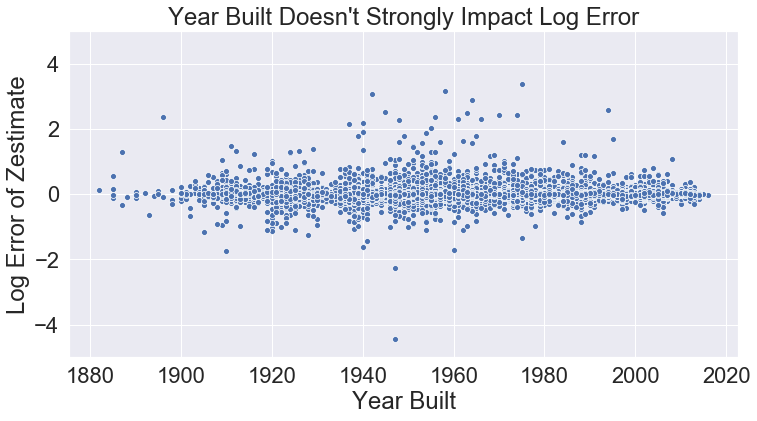

In [27]:
# setting figure size
sns.set(rc = {'figure.figsize':(12,6)})

# setting font size
sns.set(font_scale = 2)

# plotting scatterplot and setting title
plt.ylim([-5, 5])
sns.scatterplot(x = 'year_built', y = 'log_error', data = train).set_title("Year Built Doesn't Strongly Impact Log Error")

# setting x and y label
plt.xlabel("Year Built")
plt.ylabel("Log Error of Zestimate")

### Hypothesis Test - year_built

#### I'm going to perform a pearson correlation test to see if there is a linear relationship between the year a property was built and the log error produced by it's corresponding zestimate.

- H0: There is no linear relationship between year_built and log_error
<br>
- Ha: There is a linear relationship between year_built and log_error

In [28]:
# performing pearson correlation test
corr, p = stats.pearsonr(train.year_built, train.log_error)

# printing correlation coefficient and p value
print(f'alpha =                   0.05')
print(f'correlation coeffecient = {corr}')
print(f'p =                       {p}')

alpha =                   0.05
correlation coeffecient = 0.017862800951944657
p =                       0.004527406988740369


- Given that p is less than alpha I reject the null hypothesis that there is no linear relationship between year_built and log error
- That being stated, since the correlation coeffecient is almost 0, I conclude the relationship is virtually non-existent
- Since there is virtually no relationship between these two variables, I won't be using year_built as a model feature

## Feature: latitude
### Visualization - latitude
#### I will plot the relationship between latitude and log_error

Text(0, 0.5, 'Log Error of Zestimate')

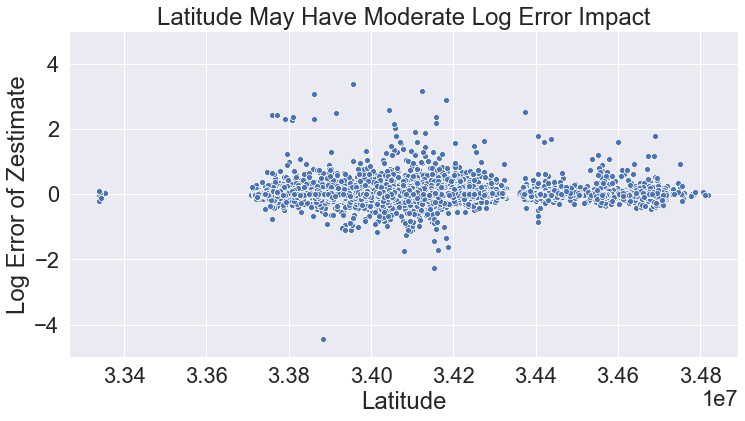

In [29]:
# setting figure size
sns.set(rc = {'figure.figsize':(12,6)})

# setting font size
sns.set(font_scale = 2)

# plotting scatterplot and setting title
plt.ylim([-5, 5])
sns.scatterplot(x = 'latitude', y = 'log_error', data = train).set_title("Latitude May Have Moderate Log Error Impact")

# setting x and y label
plt.xlabel("Latitude")
plt.ylabel("Log Error of Zestimate")

### Hypothesis Test - latitude

#### I'm going to perform a pearson correlation test to see if there is a linear relationship between the latitude of a property and the log error produced by it's corresponding zestimate.

- H0: There is no linear relationship between latitude and log_error
<br>
- Ha: There is a linear relationship between latitude and log_error

In [30]:
# performing Pearson correlation test
corr, p = stats.pearsonr(train.latitude, train.log_error)

# printing correlation coefficient and p value
print(f'alpha =                   0.05')
print(f'correlation coeffecient = {corr}')
print(f'p =                       {p}')

alpha =                   0.05
correlation coeffecient = -7.009605158193747e-05
p =                       0.9911123810876588


- Given that p is greater than alpha, I fail to reject the null hypothesis that there is no relationship between latitude and log error
- I will not be using using this variable further

## Feature: longitude
### Visualization - longitude
#### I will plot the relationship between longitude and log_error

Text(0, 0.5, 'Log Error of Zestimate')

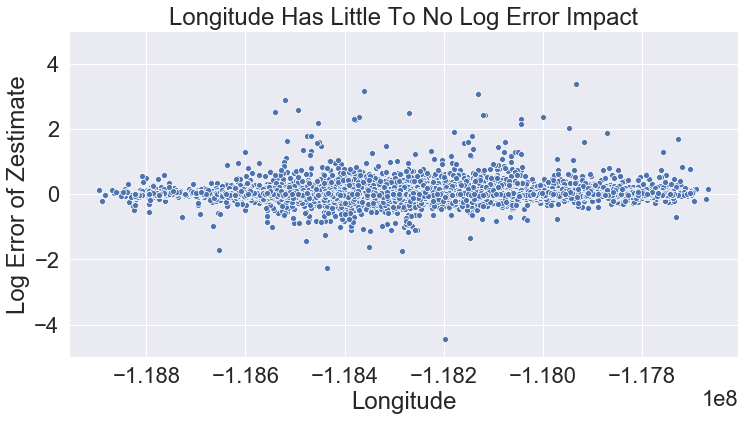

In [31]:
# setting figure size
sns.set(rc = {'figure.figsize':(12,6)})

# setting font size
sns.set(font_scale = 2)

# plotting scatterplot and setting title
plt.ylim([-5, 5])
sns.scatterplot(x = 'longitude', y = 'log_error', data = train).set_title("Longitude Has Little To No Log Error Impact")

# setting x and y label
plt.xlabel("Longitude")
plt.ylabel("Log Error of Zestimate")

### Hypothesis Test - longitude

#### I'm going to perform a pearson correlation test to see if there is a linear relationship between the longitude of a property and the log error produced by it's corresponding zestimate.

- H0: There is no linear relationship between longitude and log_error
<br>
- Ha: There is a linear relationship between longitude and log_error

In [32]:
# performing pearson correlation te
corr, p = stats.pearsonr(train.longitude, train.log_error)

# printing correlation coefficient and p value
print(f'alpha =                   0.05')
print(f'correlation coeffecient = {corr}')
print(f'p =                       {p}')

alpha =                   0.05
correlation coeffecient = 0.023028290767524044
p =                       0.00025222356333855277


- Given that p is less than alpha I reject the null hypothesis that there is no linear relationship between longitude and log error
- That being stated, since the correlation coeffecient is almost 0, I conclude the relationship is virtually non-existent
- Since there is virtually no relationship between these two variables, I won't be using longitude further

## Feature: building_quality_type_id
### Visualization - building_quality_type_id
#### I will plot the relationship between various building_quality_type_ids and log_error

In [33]:
# It will take a very long time to load the entire train df into a swarm plot so im going to take a sample instead
swarm_df = df.sample(frac=.01, replace=False, random_state=1)

(-3, 3)

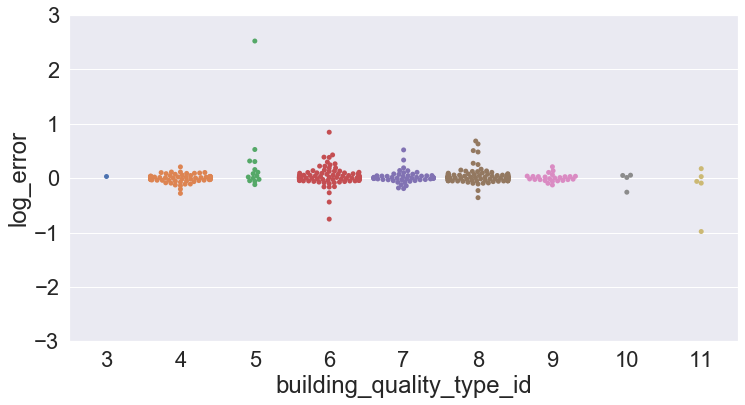

In [34]:
# creating swarmplot of log erro
ax = sns.swarmplot(x = "building_quality_type_id", y="log_error", data = swarm_df )
plt.ylim([-3, 3])

- A majority of the points for each id appear to be -.3 and .3

### Hypothesis Test - building_quality_type_id

#### I'm going to perform a chi^2 test to see if building quality type id and log error are dependent

- H0: Building quality type id and log error are not dependent
<br>
- Ha: Building quality type id and log error are dependent

In [35]:
# creating crosstab of cat adoptions vs dog adoptions
ct_bqtid = pd.crosstab(train.building_quality_type_id, train.log_error)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_bqtid)

# printing results
print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.1344


- Since p is greater than alpha, I fail to reject the null hypothesis that building quality type id and log error are not independent
- I will not be using this variable further

## Feature: heating_system_type_id
### Visualization - heating_system_type_id
#### I will plot the relationship between various heating_system_type_id and log_error

(-3, 3)

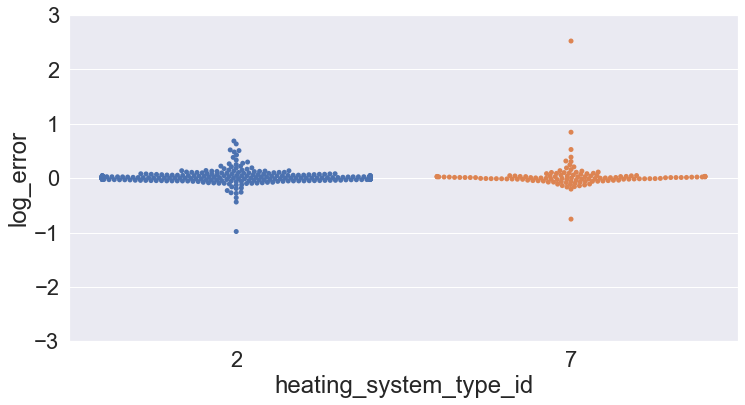

In [36]:
# creating swarmplot of log erro
ax = sns.swarmplot(x = "heating_system_type_id", y="log_error", data = swarm_df )
plt.ylim([-3, 3])

- A majority of the points for each id appear to be -.3 and .3
- Distributions are fairly similar

### Hypothesis Test - heating_system_type_id

#### I'm going to perform a chi^2 test to see if heating system type id and log error are dependent

- H0: Heating system type id and log error are not dependent
<br>
- Ha: Heating system type id and log error are dependent

In [37]:
# creating crosstab of cat adoptions vs dog adoptions
ct_hstid = pd.crosstab(train.heating_system_type_id, train.log_error)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_bqtid)

# printing results
print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.1344


- Since p is greather than alpha, I fail to reject the null hypothesis that building quality type id and log error are not independent
- I will not be using this variable further

## Feature: property_land_use_type_id
### Visualization - property_land_use_type_id
#### I will plot the relationship between various property_land_use_type_id and log_error

(-3, 3)

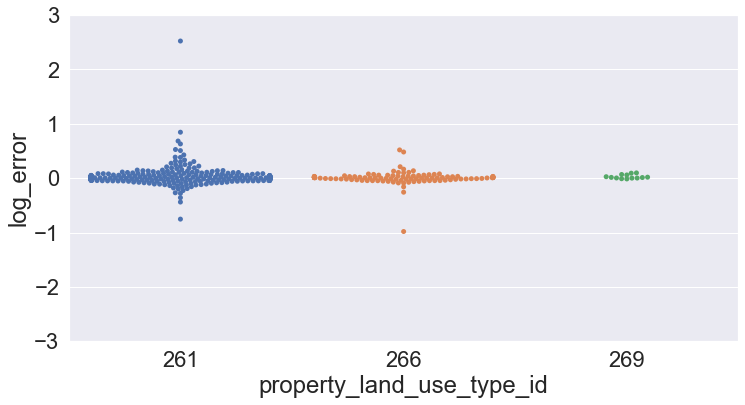

In [38]:
# creating swarmplot of log erro
ax = sns.swarmplot(x = "property_land_use_type_id", y="log_error", data = swarm_df )
plt.ylim([-3, 3])

- Most points appear to be between -.5 and .5
- Distributions appear similar except for 269 which has far fewer points than the other type ids but is still centered near 0

### Hypothesis Test - property_land_use_type_id

#### I'm going to perform a chi^2 test to see if heating system type id and property land use type id are dependent

- H0: property_land_use_type_id and log error are not dependent
<br>
- Ha: property_land_use_type_id and log error are dependent

In [39]:
# creating crosstab of cat adoptions vs dog adoptions
ct_plutid = pd.crosstab(train.property_land_use_type_id, train.log_error)

# calculating chi^2, p value, degrees of freedom and expected values
chi2, p, degf, expected = stats.chi2_contingency(ct_plutid)

# printing results
print('alpha = .05\n')
print(f'p = {p:.4f}')

alpha = .05

p = 0.1164


- Since p is greather than alpha, I fail to reject the null hypothesis that building quality type id and log error are not independent
- I won't be using this variable further

## Clustered Exploration

Exploration will now be focused on creating clusters that can used in hypothesis tests and visualizations. If the clusters' relationship with log error are meaningful, I'll use them in modeling.

It's important to cluster on scaled data when possible so the scaled version of the train dataset will be used here.

## Cluster Variable Set 1 - property_sq_ft and tax_dollar_value

To begin, I'll use subplots to see what the clusters would look like with different cluster amounts. This gives an idea of how many clusters should be chosen.

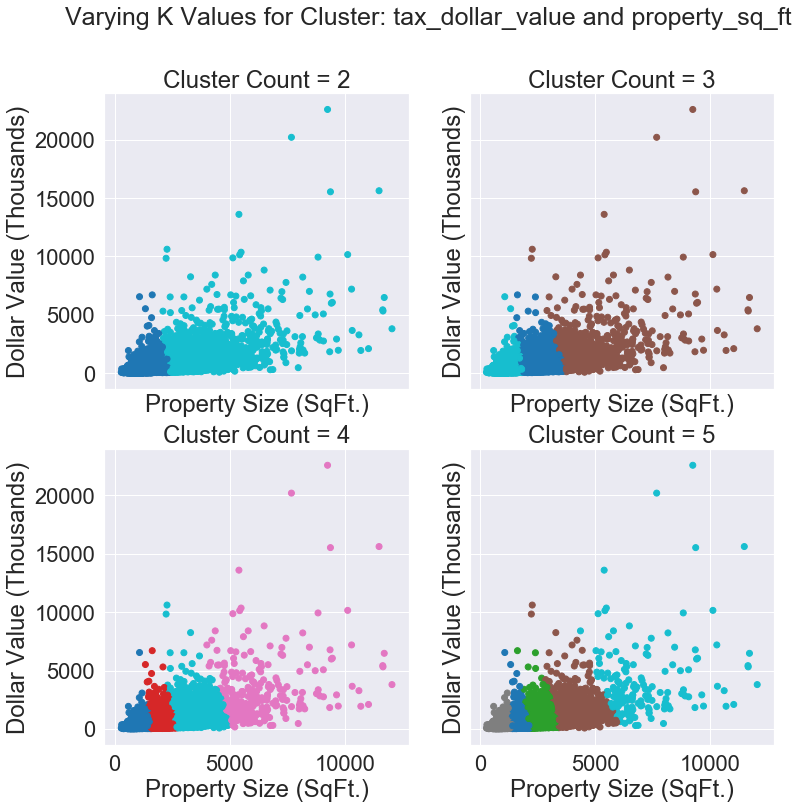

In [40]:
# creating scaled and unscaled DFs, scaled for clustering, unscaled for plotting
X_c1 = train_scaled[['property_sqft', 'tax_dollar_value']]
X_c1_unscaled = train[['property_sqft', 'tax_dollar_value']]

# setting up subplots
fig, axs = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)

# creating clusters, number of clusters increasing from 2 - 5
for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_c1).predict(X_c1)
    X_c1_unscaled['clusters'] = clusters
    plt.suptitle('Varying K Values for Cluster: tax_dollar_value and property_sq_ft',fontsize=25)
    
    # plotting 
    sns.set(font_scale = 2)
    ax.scatter(X_c1_unscaled.property_sqft, X_c1_unscaled.tax_dollar_value / 1000, c=clusters, cmap = 'tab10')
    ax.set(title='Cluster Count = {}'.format(k), xlabel='Property Size (SqFt.)', ylabel='Dollar Value (Thousands)')

- Looking for clean separation between clusters
    - All of them have relatively clean but I'm going to take 3

### Creating clusters and adding them to dataframe

In [41]:
# making copy of train so the original isn't altered
train_k1 = train.copy()

# creating kmeans object and fitting to data
kmeans_1 = KMeans(n_clusters=3, random_state = 123)
kmeans_1.fit(X_c1)

# creating clusters and adding as column
train_k1['cluster'] = kmeans_1.predict(X_c1)

### Examining clusters in-depth to identify what they each represent.

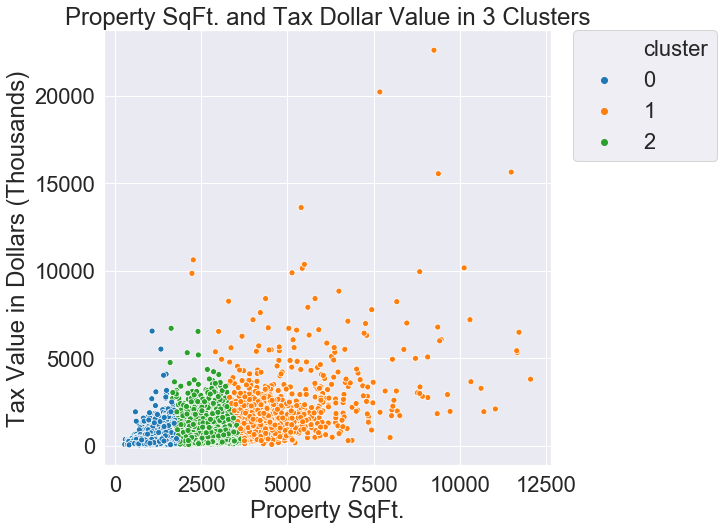

In [42]:
# setting figure and text size 
sns.set(rc = {'figure.figsize':(8,8)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling y axis values to simplify them
sns.set(font_scale = 2)
sns.scatterplot(x = train_k1['property_sqft'], y = train_k1['tax_dollar_value'] / 1000, data = train_k1, hue = 'cluster', palette = 'tab10').set_title("Property SqFt. and Tax Dollar Value in 3 Clusters")
plt.xlabel("Property SqFt.")
plt.ylabel("Tax Value in Dollars (Thousands)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Cluster 0 (Blue) is primarily 
    - low value
    - small-size properties


- Cluster 1 (Orange) is primarily 
    - low-to-mid value 
    - medium-to-large size properties
    
    
- Cluster 2 (Green) is primarily 
    - low-value 
    - small-to-medium size properties 

### Cluster Feature Set 1 - Hypothesis Test

Performing an ANOVA test to see if there are any differences between the average log errors of each cluster.

- H0 = There is no difference between the average log errors of cluster 0, cluster 1, and cluster 2
- Ha = There is a difference between the average log errors of cluster 0, cluster 1, and cluster 2

In [43]:
# creating an array for the log error of each cluster type
cluster_0 = train_k1[train_k1.cluster == 0].log_error
cluster_1 = train_k1[train_k1.cluster == 1].log_error
cluster_2 = train_k1[train_k1.cluster == 2].log_error

# performing ANOVA test
f, p = stats.f_oneway(cluster_0, cluster_1, cluster_2)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 6.2381724167095e-08


- p is less than alpha
- I reject the null hypothesis that there is no difference in log error between the clusters
- This cluster set will be used as a model feature

## Cluster Feature Set 2 - property_sq_ft and bedroom_count 

Again I'll use subplots to see what the clusters would look like with different cluster amounts. This gives an idea of how many clusters should be chosen.

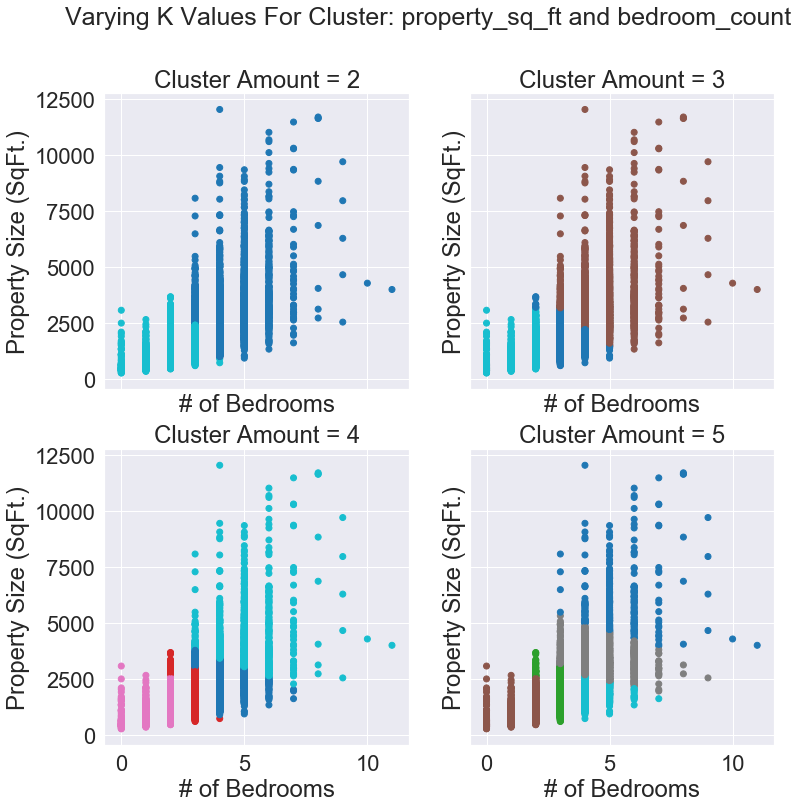

In [44]:
# creating scaled and unscaled DFs, scaled for clustering, unscaled for plotting
X_c2 = train_scaled[['bedroom_count','property_sqft']]
X_c2_unscaled = train[['bedroom_count','property_sqft']]

# setting up subplots
fig, axs = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)

# creating clusters, number of clusters increasing from 2 - 5
for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_c2).predict(X_c2)
    X_c2_unscaled['clusters'] = clusters
    plt.suptitle('Varying K Values For Cluster: property_sq_ft and bedroom_count',fontsize=25)
    
    # plotting 
    sns.set(font_scale = 2)
    ax.scatter(X_c2_unscaled.bedroom_count, X_c2_unscaled.property_sqft, c=clusters, cmap = 'tab10')
    ax.set(title='Cluster Amount = {}'.format(k), ylabel='Property Size (SqFt.)', xlabel = '# of Bedrooms')

- Again I'm looking for good separation between clusters
    - 2 and 3 look promising but I'm going to go with 2 since the separation seems a bit cleaner
- Property square feet seems to be having a strong influence on our clusters since it was in both feature sets and we're seeing similar splits

### Creating clusters and adding them to dataframe

In [45]:
# making copy of train so the original isn't altered
train_k2 = train.copy()

# creating kmeans object and fitting to data
kmeans_2 = KMeans(n_clusters=2, random_state=123)
kmeans_2.fit(X_c2)

# creating clusters and adding as column
train_k2['cluster'] = kmeans_2.predict(X_c2)

### Examining clusters in-depth and identify what they each represent.

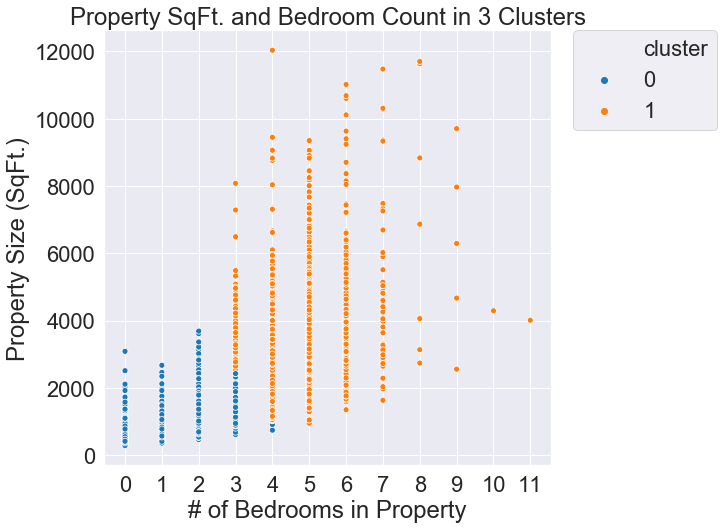

In [46]:
# setting figure and text size 
sns.set(rc = {'figure.figsize':(8,8)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling y axis values to simplify them
sns.scatterplot(x = train_k2['bedroom_count'], y = train_k2['property_sqft'], data = train_k2, hue = 'cluster', palette = 'tab10').set_title("Property SqFt. and Bedroom Count in 3 Clusters")
plt.ylabel("Property Size (SqFt.)")
plt.xlabel("# of Bedrooms in Property")
plt.xticks(np.arange(0, 12, 1.0))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Cluster 0 (Blue) is primarily 
    - low bedroom count
    - small size properties
    
    
- Cluster 1 (Orange) is primarily
    - medium-to-high bedroom count
    - medium-to-large size properties

### Cluster Feature Set 2 - Hypothesis Test 

Now that the characterstics of the clusters have been identified, I'll perform a t-test to see if there is any difference in their average log errors.

- H0 = There is no difference between the average log errors of cluster 0 and cluster 1
- Ha = There is a difference between the average log errors of cluster 0 and cluster 1

In [47]:
# creating an array for the log error of each cluster type
cluster_0 = train_k2[train_k2.cluster == 0].log_error
cluster_1 = train_k2[train_k2.cluster == 1].log_error

# performing 2 tailed, 2 sample t-test
t, p = stats.ttest_ind(cluster_0, cluster_1)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 7.270203238637099e-09


- p is less than alpha
- I reject the null hypothesis that there is no difference in the average log error of the clusters
- These clusters will be used in modeling

## CLUSTER FEATURE SET 3 - Bedroom_Count and Tax_Dollar_Value 

Again I'll use subplots to see what the clusters would look like with different cluster amounts. This gives an idea of how many clusters should be chosen.

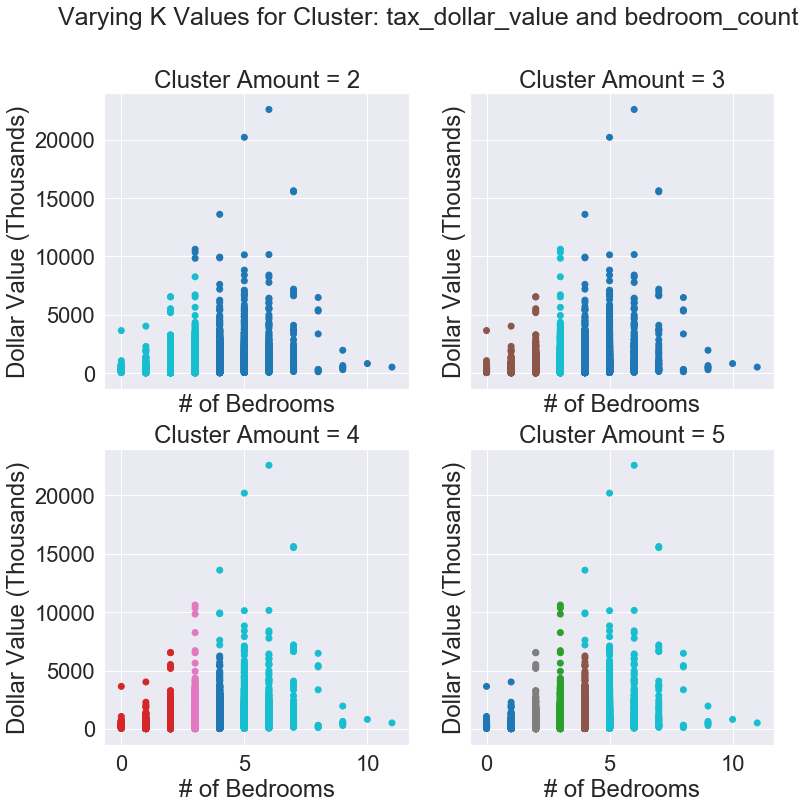

In [48]:
# creating scaled and unscaled DFs, scaled for clustering, unscaled for plotting
X_c3 = train_scaled[['bedroom_count','tax_dollar_value']]
X_c3_unscaled = train[['bedroom_count','tax_dollar_value']]

# setting up subplots
fig, axs = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True)

# creating clusters, number of clusters increasing from 2 - 5
for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X_c3).predict(X_c3)
    X_c3_unscaled['clusters'] = clusters
    plt.suptitle('Varying K Values for Cluster: tax_dollar_value and bedroom_count',fontsize=25)
    
    # plotting 
    sns.set(font_scale = 2)
    ax.scatter(X_c3_unscaled.bedroom_count, X_c3_unscaled.tax_dollar_value / 1000, c = clusters, cmap = 'tab10')
    ax.set(title='Cluster Amount = {}'.format(k), ylabel='Dollar Value (Thousands)', xlabel='# of Bedrooms')

- Still looking for clean separation between clusters
- Going to use 2 in this case

### Creating clusters and adding them to dataframe

In [49]:
# making copy of train so we don't alter the original
train_k3 = train.copy()

# creating kmeans object and fitting to data
kmeans_3 = KMeans(n_clusters = 2, random_state=123)
kmeans_3.fit(X_c3)

# creating clusters and adding as column
train_k3['cluster'] = kmeans_3.predict(X_c3)

### Examining clusters in-depth and identify what they each represent.

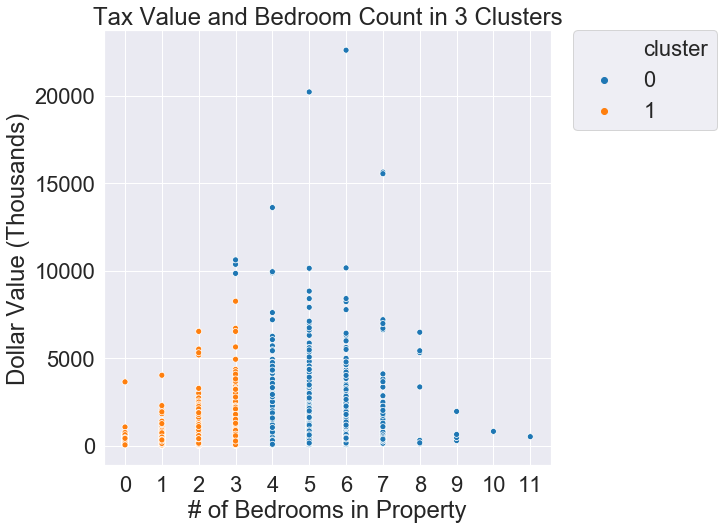

In [50]:
# setting figure and text size 
sns.set(rc = {'figure.figsize':(8,8)})
sns.set(font_scale = 2)

# plotting data, setting title and scaling y axis values to simplify them
sns.scatterplot(x = train_k3['bedroom_count'], y = train_k3['tax_dollar_value']/1000, data = train_k3, hue = 'cluster', palette = 'tab10').set_title("Tax Value and Bedroom Count in 3 Clusters")
plt.ylabel("Dollar Value (Thousands)")
plt.xlabel("# of Bedrooms in Property")
plt.xticks(np.arange(0, 12, 1.0))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

- Cluster 0 (Blue) is primarily
    - Medium-to-high bedroom count, low-to-medium value properties
    
- Cluster 1 (Orange) is primarily
    - Low-to-medium bedroom count, low-to-medium value properties

## Cluster Feature set 3 - Hypothesis Test

Now that the characterstics of the clusters have been identified, I'll perform an t-test to see if there is any difference between their average log errors.

- H0 = There is no difference between the average log errors of cluster 0 and cluster 1
- Ha = There is a difference between the average log errors of cluster 0 and cluster 1

In [51]:
# creating an array for the log error of each cluster type
cluster_0 = train_k3[train_k3.cluster == 0].log_error
cluster_1 = train_k3[train_k3.cluster == 1].log_error

# performing 2 tailed, 2 sample t-test
t, p = stats.ttest_ind(cluster_0, cluster_1)

# printing results
print(f'alpha = .05\n')
print (f'p = {p}')

alpha = .05

p = 1.5967848449236026e-08


- p is less than alpha so I reject the null hypothesis that there is no difference between the average log errors of cluster 0 and cluster 1

- I will be using these clusters as features in modeling

### Exploration Takeaways

__Non-Clustered Exploration__


- Visualization and hypothesis tests suggest that log_error is influenced by the following variables
    - property_sq_ft
    - tax_dollar_value
    - bedroom_count
    - bathroom count


__Clustered Exploration__


- Created 3 clusters for each pair of variables below
    - Variable set 1: property_sq_ft and tax_dollar_value
    - Variable set 2: property_sq_ft and bedroom_count
    - Variable set 3: bedroom_count and tax_dollar_value


- Ran hypothesis tests on each set of clusters to determine if there were any differences in log error
    - All tests reflected differences in average log errors between clusters 


__Moving Forward__


- Now moving into modeling with the following variables
    - tax_dollar_value
    - property_sq_ft
    - bedroom_count
    - bathroom_count
    - Cluster set 1 (property_sq_ft and tax_dollar_value)
    - Cluster set 2 (property_sq_ft and bedroom_count)
    - Cluster set 3 (bedroom_count and tax_dollar_value)
***

## Modeling
I'm going to construct several models that will attempt to predict the log error associated with each property. 

I'm also creating a __model.py__ file that contains the custom functions used in this phase.

***

## TRAIN
Creating a baseline model that the other models will attempt to outperform.

Afterwards I'll create 4 alternate models. The 2 best that outperform the baseline will be used on the validation sample.

### Baseline Model<a name="bm"></a>
Creating a baseline model using __baseline_function (model.py)__ that will always predict log error to be the sample's average log error. 

The RMSE value is predictions produce will also serve as the benchmark that our alternate models will seek to outperform.

In [52]:
baseline_function(train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.154733


- Baseline RMSE is .154544 and the metric our other models need to improve upon (IE. having lower RMSE)

### Model 1 
Creating a model using __model_1_function (model.py)__ that uses cluster set 1 (property_sq_ft and tax_dollar_value clusters) in addition to bathroom and bedroom count. 

Model type: Linear Regression


Model Features 
- bedroom_count
- bathroom_count
- cluster set 1
    - cluster features: property_sq_ft and tax_dollar_value
    - number of clusters: 3

In [53]:
model_1_function(train_scaled, train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.154579


### Model 2
Creating a model using __model_2_function (model.py)__ that uses tax_dollar_value and bedroom_count in addition to cluster set 2 (property_sqft and bedroom_count) as features.

Model type: Linear Regression


Model Features 
- tax_dollar_value
- bathroom_count
- cluster set 2
    - cluster features: tax_dollar_value and bedroom_count
    - number of clusters: 2

In [54]:
model_2_function(train_scaled, train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.154509


### Model 3
Creating a model using __model_3_function (model.py)__ that uses tax_dollar_value and bathroom_count in addition to cluster set 3 (property_sqft and bedroom_count) as features.

Model type: Linear Regression


Model Features 
- tax_dollar_value
- bathroom_count
- cluster set 3
    - cluster features: property_sq_ft and bedroom_count
    - number of clusters: 2

In [55]:
model_3_function(train_scaled, train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.154625


### Model 4
Creating a model using __model_4_function (model.py)__ that uses tax_dollar_value, bathroom_count, bedroom_count, and property_sqft as features (no clusters).

Model type: Linear Regression


Model Features 
- tax_dollar_value
- bathroom_count
- bedroom_count
- property_sqft

In [56]:
model_4_function(train_scaled, train_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.154409


- Model 2 and model 4 had the lowest RMSE values so they'll be used on the validate data set
- Model 4 had the lowest RMSE value so this may be an indicator that the clusters aren't as effective as their source variables but more testing is needed

### VALIDATE
The top 2 models from the train dataset phase will now be used on the validate dataset.

The best model model will be used to the test sample.

### Model 2 (tax_dollar_value and bedroom_count cluster model)

In [57]:
model_2_function(train_scaled, validate_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.160889


### Model 4 (No Clusters Model)

In [58]:
model_4_function(train_scaled, validate_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.160914


- This gives me an idea of how the models will perform on unseen data (out of sample)
- Model 2 outperformed model 4 so it will be taken to the test phase
- The cluster model outperformed the non-cluster model in validate (out-of-sample) but not on train (in-sample)

### TEST
Our best model from the validate phase will now be used on the test dataset.

### Model 2 (No Clusters Model)

In [59]:
model_2_function(train_scaled, test_scaled)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.142531


- Model 2's performance on the validate set was stronger than on the test set

### Modeling Takeaways

Created 5 models 
    
- Baseline
    - Always predicts average logerror
        
        
- Model 1
    - Linear Regression
    - Features 
        - bedroom_count
        - bathroom_count
        - cluster set 1
            - cluster variables: property_sq_ft and tax_dollar_value
            - number of clusters: 3
                
                
- Model 2
    - Linear Regression
    - Features
        - property_sq_ft
        - bathroom count
        - cluster set 2
            - cluster variables: tax_dollar_value and bedroom_count
            - number of clusters: 2
            
            
- Model 3 
    - Linear Regression
    - Features 
        - bathroom_count
        - tax_dollar_value
        - cluster set 3
            - cluster variables: property_sq_ft and bedroom_count
            - number of clusters: 2
            
- Model 4
    - Linear Regression
    - Features
        - property_sq_ft
        - bathroom count
        - bedroom_count
        - tax_dollar_value

Best Model
- Model 2
    - Proved to be best model by outperforming the other models with regard to RMSE value on predictions for log error
    - Performed better on validate sample than on test sample
    
All custom functions used in this phase are available in the __model.py__ file located in this repository.
***

## Conclusion<a name="con"></a>

__Summary of Findings__

- Explored many variables via plots and hypothesis tests and found the following to be viable for predicting log error
    - bathroom_count
    - bedroom_count
    - property_sq_ft
    - tax_dollar_value


- Created clusters from various combinations of bedroom_count, tax_dollar_value and  property_sq_ft and found statistical signifgance between the average log errors between each combination respective set of clusters 


- Created several models including a baseline that always predicted logerror to be the sample average

- Each model's performance was evaluated based on RMSE produced by comparing its prediction of logerror values vs. actual log error values

- Model 2 was the best performer 
    - Linear Regression
    - Features
        - property_sq_ft
        - bathroom count
        - cluster set 2
            - cluster variables: tax_dollar_value and bedroom_count
            - number of clusters: 2


__Recommendation__
- Begin a project to improve the accuracy of our zillow estimate software using the insights and model generated from this project


__Expectations__
- By improving the accuracy of our zestimates we will increase satisfaction among our current users and make our services more attractive to potential users. 


__In the future__
- Create clusters that include bathroom count as this variable is not included in any feature combinations currently
- Cluster latitude and longitude to see how their clusters relate to log error
***